# Generate the model from processed.csv

imports

In [14]:
from sklearn import clone
from sklearn.base import RegressorMixin, TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
import smogn
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import json


Read CSV

In [ ]:

df = pd.read_csv('data/processed.csv')

print('Before smogn, unbalanced data size', df.shape)


# makes models perform worse
# df['difficulty_transform'], lambda_value = stats.boxcox(df['difficulty'])

# Apply SMOTER on the most unbalanced difficulty levels: 2,4 and 5
df_smogn = smogn.smoter(
    data = df, 
    y = "difficulty",
    samp_method="extreme",
    rel_method="manual",    
    rel_ctrl_pts_rg= [
            [0, 1, 0],
            [0.5, 1, 0],
            [1, 1, 0],
            [1.5, 1, 0],
            [2, 0, 0],
            [2.5, 1, 0],
            [3, 1, 0],
            [3.5, 1, 0],
            [4, 0, 0],
            [4.5, 1, 0],
            [5, 0, 0],
        ]
)

print('After smogn', df_smogn.shape)



Before smogn, unbalanced data size (264, 25)


r_index: 100%|##########| 3/3 [00:00<00:00, 230.77it/s]

After smogn (690, 25)


## Selecting best features

In [43]:
X = df_smogn.drop(columns=['difficulty'])
y = df_smogn['difficulty']


features_names = X.columns


# Keep the best features
selector = SelectPercentile(r_regression, percentile=40)
X = selector.fit_transform(X, y)
features_kept = features_names[selector.get_support()]
print("Features kept:", features_kept)


Features kept: Index(['note_count', 'unique_note_count', 'overlapping_notes', 'pitch_range',
       'tempo_change_count', 'max_polyphony', 'note_to_note_transition',
       'note_to_chord_transition', 'chord_to_note_transition',
       'chord_to_chord_transition'],
      dtype='object')


## Scaling data and splitting
features have a large difference in scale, scaling makes model perform slightly better

In [44]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Removes randomness from the model across runs
rng = np.random.RandomState(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)


## Tuning hyperparameters

In [ ]:
model_params = {
  'XGB': {
    'model': XGBRegressor(random_state=rng),
    'params': {
        'n_estimators': [100, 200, 500, 1000],
        'gamma': [0.005, 0.01, 0.1, 0],
        'max_depth': [1, 2, 3, 6, 9],
        'learning_rate': [0.001, 0.01, 0.1, 0.015, 1],
        'min_child_weight': [1, 2, 3],
    }
  },
  'RandomForest': {
    'model': RandomForestRegressor(random_state=rng),
    'params': {
      'n_estimators': [100, 200, 500],
      'max_features': ['sqrt', 'log2', None],
      'min_samples_split': [2, 5, 10],
      'max_depth': [None, 1, 2, 10, 20, 30],
      'max_leaf_nodes': [None, 2, 5, 10],
    }
  },
  'SVR': {
    'model': SVR(),
    'params': {
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'C': [0.1, 1, 10, 20, 50, 100],
      'gamma': ['scale', 'auto'],
    }
  },
  'LinearRegression': {
    'model': LinearRegression(),
    'params': {
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    }
  },
  'Ridge': {
    'model': Ridge(random_state=rng),
    'params': {
      'alpha': [0.1, 1, 10, 100],
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    }
  },
  'Lasso': {
    'model': Lasso(random_state=rng),
    'params': {
      'alpha': [0.1, 1, 10, 100],
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    },
  },
  'ElasticNet': {
    'model': ElasticNet(random_state=rng),
    'params': {
      'alpha': [0.1, 1, 10, 100],
      'l1_ratio': [0.1, 0.5, 0.9],
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    },
  },
}

results =  {}

for name, config in model_params.items():
  print('tuning hyperparamerts for ', name)
  # Can edit cv to be more or less, less is faster
  grid_search = GridSearchCV(config['model'], config['params'], cv=3, scoring='r2')
  grid_search.fit(X_train, y_train)
  
  results[name] = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
  }
  
  print(f"Best parameters for {name}:", grid_search.best_params_)
  print(f"Best cross-validation score for {name}:", grid_search.best_score_)

with open(f'model_params.json', 'w') as f:
    json.dump(results, f)

tuning hyperparamerts for  LinearRegression
Best parameters for LinearRegression: {'copy_X': True, 'fit_intercept': True}
Best cross-validation score for LinearRegression: 0.6883422140029883
tuning hyperparamerts for  Ridge
Best parameters for Ridge: {'alpha': 1, 'copy_X': True, 'fit_intercept': True}
Best cross-validation score for Ridge: 0.7299000359080617
tuning hyperparamerts for  Lasso
Best parameters for Lasso: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': False}
Best cross-validation score for Lasso: 0.6834461091340264
tuning hyperparamerts for  ElasticNet
Best parameters for ElasticNet: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': False, 'l1_ratio': 0.9}
Best cross-validation score for ElasticNet: 0.6854046940222697


In [45]:
with open ('model_params.json', 'r') as f:
    params = json.load(f)
    
models = {
    'XGB': XGBRegressor(**params['XGB']['best_params']),
    'RandomForest': RandomForestRegressor(**params['RandomForest']['best_params']),
    'LinearRegression':  LinearRegression(**params['LinearRegression']['best_params']),
    'Ridge': Ridge(**params['Ridge']['best_params']),
    'Lasso': Lasso(**params['Lasso']['best_params']),
    'ElasticNet': ElasticNet(**params['ElasticNet']['best_params']),
    'SVR': SVR(**params['SVR']['best_params'])
}


Validation Function

In [46]:
n_folds = 5

def rmse_cross_validation(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [47]:
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    print(f"Model: {name}")
    # Round and clip to ensure valid difficulty levels
    y_pred = np.round(model.predict(X_test) * 2) / 2
    print("Mean squared error:", mean_squared_error(y_test, y_pred))
    print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
    print("R^2 score:", r2_score(y_test, y_pred))
    print("Root mean squared error:", rmse_cross_validation(model).mean())
    print("======================")
    # Save model to disk
    with open(f'./models/{name}_saved_model.pkl', 'wb') as file:
      pickle.dump(model, file)

Model: XGB
Mean squared error: 0.2391304347826087
Mean absolute error: 0.2608695652173913
R^2 score: 0.8773704937897607
Root mean squared error: 0.3713906638367855
Model: RandomForest
Mean squared error: 0.13043478260869565
Mean absolute error: 0.13043478260869565
R^2 score: 0.9331111784307786
Root mean squared error: 0.28938904323093945
Model: LinearRegression
Mean squared error: 0.5271739130434783
Mean absolute error: 0.48188405797101447
R^2 score: 0.7296576794910634
Root mean squared error: 0.6449605567056332
Model: Ridge
Mean squared error: 0.4891304347826087
Mean absolute error: 0.4782608695652174
R^2 score: 0.7491669191154195
Root mean squared error: 0.6395162287505025
Model: Lasso
Mean squared error: 0.6884057971014492
Mean absolute error: 0.5652173913043478
R^2 score: 0.6469756639402202
Root mean squared error: 0.7033859227485733
Model: ElasticNet
Mean squared error: 0.6902173913043478
Mean absolute error: 0.5688405797101449
R^2 score: 0.6460466525295365
Root mean squared error

## Create Buckets for each model

Do this to check where the model is performing well and where it is not. Here, we visualize it. Low is 0 - 1.5, mid is 1.5 - 3.5, high is 3.5 - 5.

MAE scores per bucket for XGB bucket
low (1-2)         0.180658
medium (2-3.5)    0.306875
high (3.5-5)      0.373774
dtype: float64
MSE scores per bucket for XGB bucket
low (1-2)         0.055222
medium (2-3.5)    0.158137
high (3.5-5)      0.407497
dtype: float64


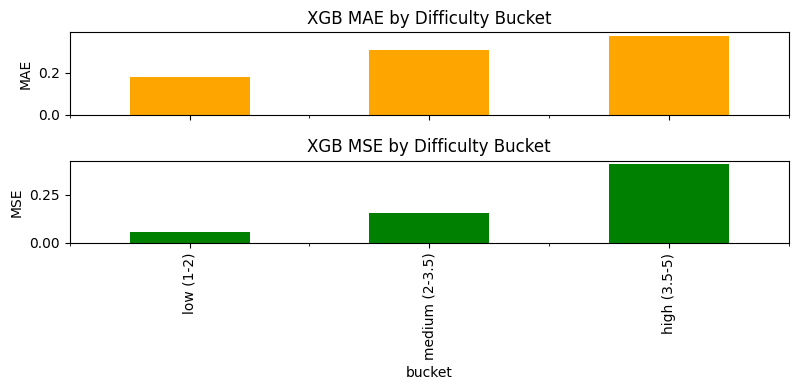

MAE scores per bucket for RandomForest bucket
low (1-2)         0.128886
medium (2-3.5)    0.220458
high (3.5-5)      0.222446
dtype: float64
MSE scores per bucket for RandomForest bucket
low (1-2)         0.039908
medium (2-3.5)    0.089235
high (3.5-5)      0.206867
dtype: float64


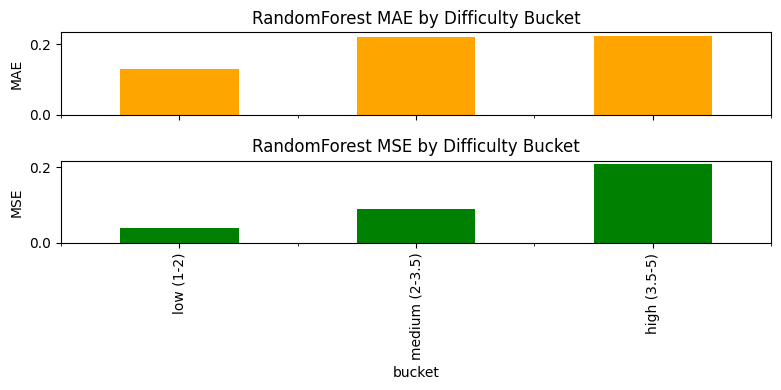

MAE scores per bucket for LinearRegression bucket
low (1-2)         0.358202
medium (2-3.5)    0.439179
high (3.5-5)      0.700477
dtype: float64
MSE scores per bucket for LinearRegression bucket
low (1-2)         0.183473
medium (2-3.5)    0.395966
high (3.5-5)      0.975794
dtype: float64


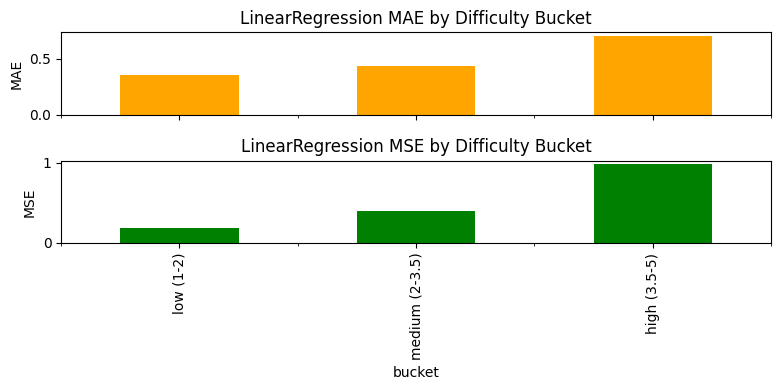

MAE scores per bucket for Ridge bucket
low (1-2)         0.391980
medium (2-3.5)    0.423292
high (3.5-5)      0.696271
dtype: float64
MSE scores per bucket for Ridge bucket
low (1-2)         0.206071
medium (2-3.5)    0.371525
high (3.5-5)      0.949016
dtype: float64


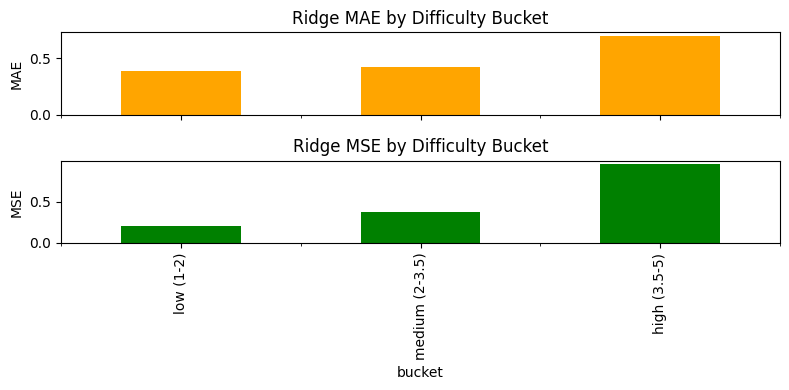

MAE scores per bucket for Lasso bucket
low (1-2)         0.420489
medium (2-3.5)    0.355014
high (3.5-5)      0.907733
dtype: float64
MSE scores per bucket for Lasso bucket
low (1-2)         0.291202
medium (2-3.5)    0.226859
high (3.5-5)      1.306051
dtype: float64


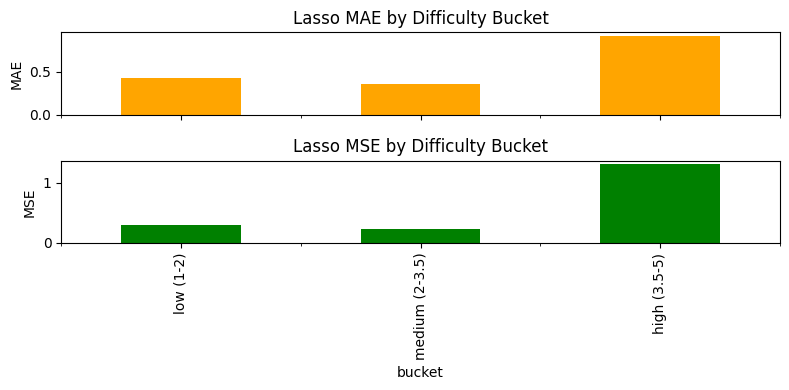

MAE scores per bucket for ElasticNet bucket
low (1-2)         0.403448
medium (2-3.5)    0.350955
high (3.5-5)      0.940718
dtype: float64
MSE scores per bucket for ElasticNet bucket
low (1-2)         0.277172
medium (2-3.5)    0.219494
high (3.5-5)      1.359650
dtype: float64


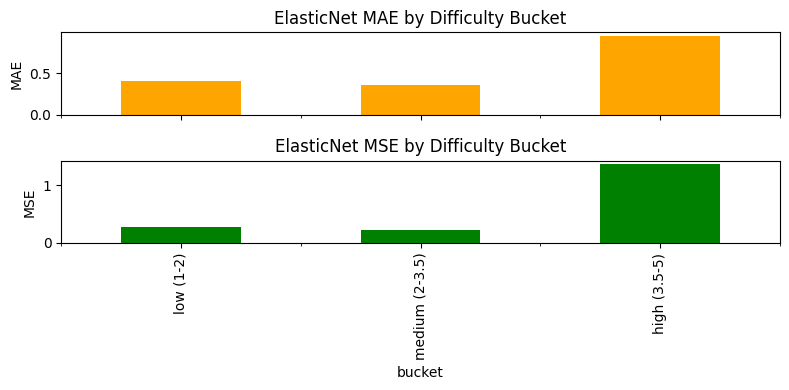

MAE scores per bucket for SVR bucket
low (1-2)         0.174100
medium (2-3.5)    0.322948
high (3.5-5)      0.514208
dtype: float64
MSE scores per bucket for SVR bucket
low (1-2)         0.057528
medium (2-3.5)    0.176304
high (3.5-5)      0.874243
dtype: float64


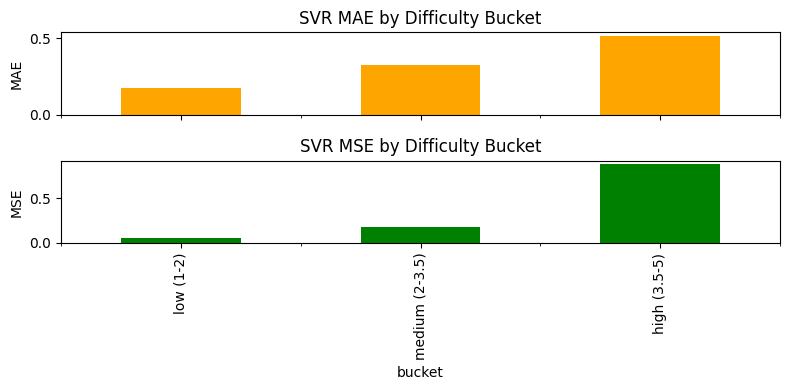

In [48]:
for name, prediction in predictions.items():
    # Comparing true values vs predicted
    df = pd.DataFrame({
      'true': y_test,
      'pred': prediction,
    })
      
    df['bucket'] = pd.cut(df['true'], 
               bins=[0, 2, 3.5, 5],
               labels=['low (1-2)', 'medium (2-3.5)', 'high (3.5-5)'],
               include_lowest=True)
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

    mae_scores = df.groupby('bucket', observed=True)[['true', 'pred']].apply(lambda g: mean_absolute_error(g['true'], g['pred']))
    
    print(f'MAE scores per bucket for {name}', mae_scores)
    mae_scores.plot(kind='bar', ax=axes[0], title=f"{name} MAE by Difficulty Bucket", ylabel="MAE", color='orange', legend=False)

    mse_scores = df.groupby('bucket', observed=True)[['true', 'pred']].apply(lambda g: mean_squared_error(g['true'], g['pred']))
    
    print(f'MSE scores per bucket for {name}', mse_scores)
    mse_scores.plot(kind='bar', ax=axes[1], title=f"{name} MSE by Difficulty Bucket", ylabel="MSE", color='green', legend=False)

    plt.tight_layout()
    plt.show()

## AveragingModel using the models trained earlier

In [49]:
# referenced from https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, scaler, weights_by_bucket=None):
        self.models = models
        self.scaler = scaler
        self.weights_by_bucket = weights_by_bucket

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

From the earlier plots, we can see that the model is performing well in the low and mid buckets, but not so well in the high bucket. To try and lessen this effect we average the performance of the best performing models: Xgboost and RandomForest.

In [62]:
models_to_use = [models['RandomForest']]
averaged_models = AveragingModels(models=models_to_use, scaler = scaler)
score = rmse_cross_validation(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(X_train, y_train)
y_pred = np.round(averaged_models.predict(X_test) * 2) / 2

print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

with open(f'./models/averaged_models.pkl', 'wb') as file:
    pickle.dump(averaged_models, file)



 Averaged base models score: 0.2865 (0.0386)

Mean squared error: 0.09601449275362318
Mean absolute error: 0.11956521739130435
R^2 score: 0.9507623952337676


# Predicting the difficulty for the rest of the songs

In [63]:
with open('./models/averaged_models.pkl', 'rb') as file:
    averaged_models = pickle.load(file)

df = pd.read_csv('data/all_song_features.csv')

# Select only the columns used during training
X_unseen = df.loc[:, features_kept]

# Scale the data using the same scaler from training
X_unseen = scaler.transform(X_unseen)

y_pred = np.round(averaged_models.predict(X_unseen) * 2) / 2

predictions = pd.DataFrame({
    'file': df['file'],
    'predicted_difficulty': y_pred
}).to_csv('predictions.csv', index=False)



c:\Users\tanbi\OneDrive\Desktop\projects\music-ai\music-difficulty-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
